In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import random
import numpy as np

## CUDA Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)              

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x


In [4]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI_volumes/173940")
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI_volumes/173940")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 256, 256, 256)),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [-1, 1])),
                    ])
ds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,3))
print(ds, "\n")
print(ds.info(nsamples=1))

{'name': 'UndersampledUltrasoundDataset3D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI_volumes/173940', 'maxsamples': None, 'transform': Compose(
    Lambda()
    Lambda()
    Lambda()
), 'undersample_width': (1, 1, 3), 'mode': 'mri', 'fill': 0.0, 'len': 1} 



/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'max': tensor(1.), 'min': tensor(-1.), 'mean': tensor(-0.2343), 'std': tensor(0.4110), 'shape': torch.Size([256, 256, 256])}


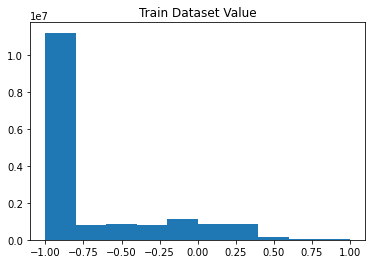

In [5]:
data = []
for i in range(len(ds)):
    data += list((ds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

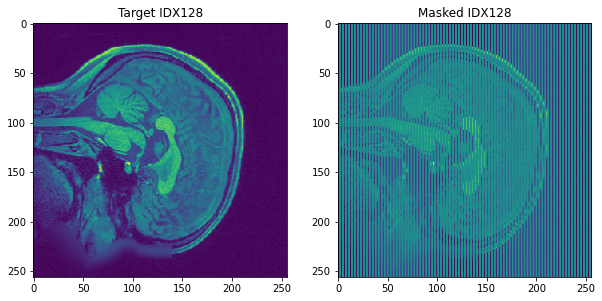

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
idx = int(ds[0][1].shape[0]/2)
tgt = axs[0].imshow(ds[0][1][idx], vmin=-1, vmax=1)
axs[0].set_title("Target IDX%g"%idx)
msk = axs[1].imshow(ds[0][0][idx], vmin=-1, vmax=1)
axs[1].set_title("Masked IDX%g"%idx)
plt.show()


# Model 

In [7]:
def make_model(nc=64):
    channels = (16, 32, 64, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=2,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)
print(make_model())

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


DataParallel(
  (module): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
          (unit1): Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
        )
        (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
          (0): ResidualUnit(
   

# Train and Validate Functions

In [8]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    """ Trains one epoch, validates with MSE """
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates model with criterion and MSE"""
    model.eval()

    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

In [14]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses, all_train_mse, all_valid_mse = [], [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            train_loss, train_mse = train(model, train_loader, optimizer, loss, device)
            all_train_losses.append(train_loss.item())
            all_train_mse.append(train_mse.item())
            if valid_loader is not None:
                valid_loss, valid_mse = validate(model, valid_loader, loss, device)
                all_valid_losses.append(valid_loss.item())
                all_valid_mse.append(valid_mse.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item(), "train_mse":train_mse.item()}#, "valid_loss": valid_loss.item(), "valid_mse":valid_mse.item()}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 10))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(all_train_losses, label="train")
                if valid_loader is not None:
                    axs[0].plot(all_valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(all_train_mse, label="train")
                if valid_loader is not None:
                    axs[1].plot(all_valid_mse, label="valid")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx], vmin=-1., vmax=1.)
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy(), vmin=-1., vmax=1.)
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx], vmin=-1., vmax=1.)
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                loss_list = [str(l) for l in loss.losses]
                                awloss = loss.losses[loss_list.index("AWLoss()")]
                                v, T = awloss.filters[0], awloss.T
                            
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())


            plt.show()

# Training Setup

In [15]:
# Set training static parameters and hyperparameters
nepochs=1000                        
learning_rate=1e-3
batch_size=1                                        

# Dataloader
train_loader = DataLoader(ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = None


# Sample for visualisation
x_sample, y_sample = ds[0]

# Joint Loss

In [16]:
from math import log, floor
class JointLoss(nn.Module):
    def __init__(self, losses, weights, norm=False):
        super(JointLoss, self).__init__()
        self.losses = losses
        self.weights = weights
        self.norm = norm

    def __str__(self):
        name = ""
        for l , w in zip(self.losses, self.weights):
            name += "{}(w={:.1E}) ".format(str(l)[:-2], w)
        return name[:-1]

    def scale(self, x):
        if self.norm:
            return x / 10**floor(log(x, 10))
        else:
            return x

    def forward(self, x, y):
        total_loss = 0.
        for l, w in zip(self.losses, self.weights):
            total_loss += w * self.scale(l(x, y))
        return total_loss

# Train MSE Loss



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 1.0761122703552246, 'train_mse': 1.0761122703552246}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])


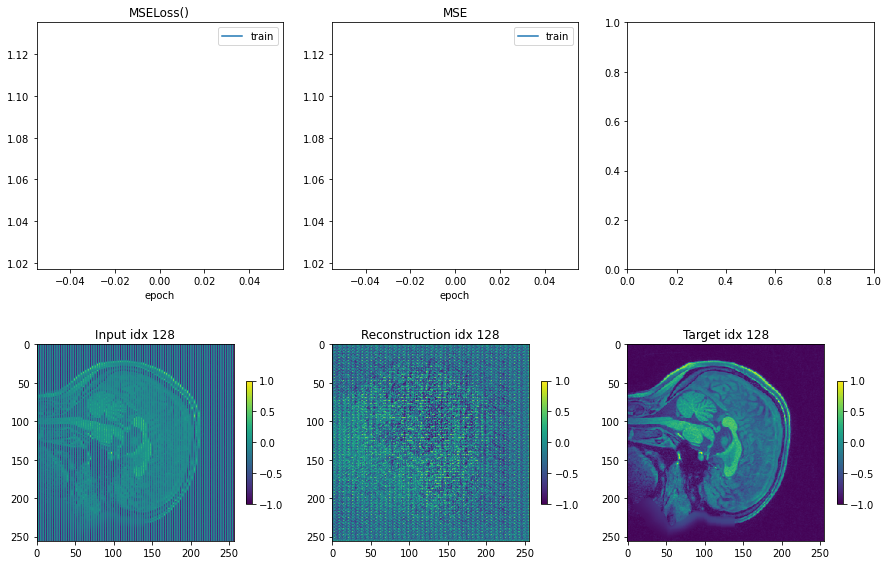

 25% (150 of 600) |#####                 | Elapsed Time: 0:23:15 ETA:   1:13:17


 {'epoch': 150, 'train_loss': 0.03592223674058914, 'train_mse': 0.03592223674058914}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])


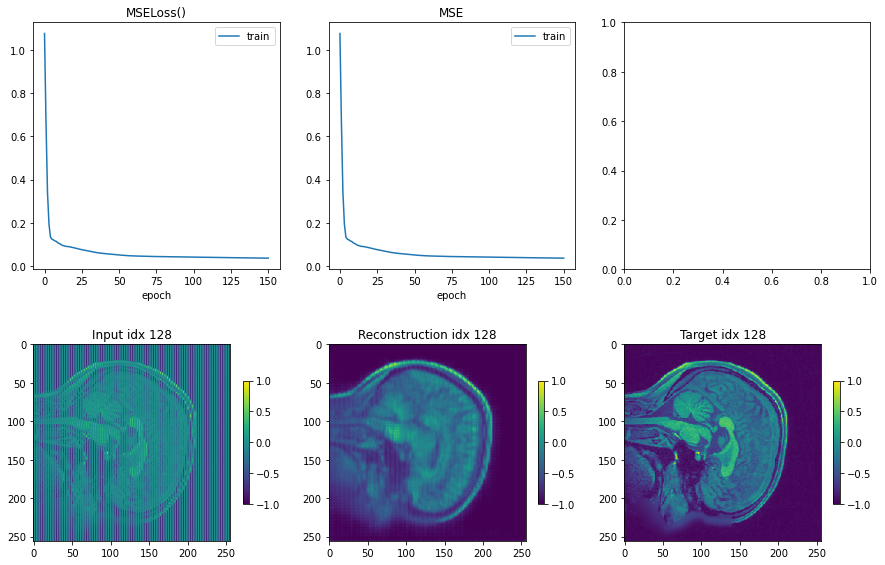

100% (600 of 600) |######################| Elapsed Time: 0:25:47 Time:  0:25:47


KeyboardInterrupt: 

In [17]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mseloss     = nn.MSELoss(reduction="mean")

train_model(model, optimizer, mseloss, train_loader,  valid_loader=valid_loader, nepochs=600, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 180.31488037109375, 'train_mse': 1.0874087810516357}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 18113657


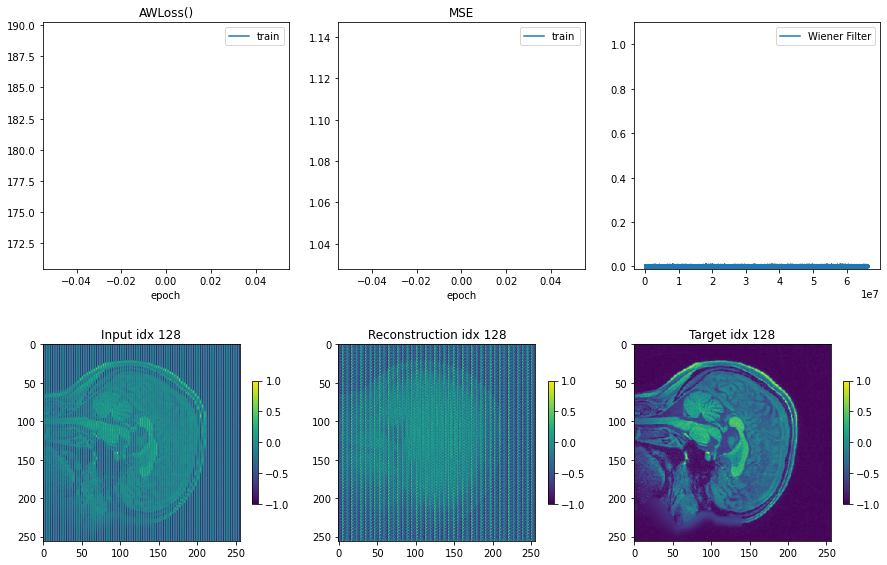

 15% (150 of 1000) |###                  | Elapsed Time: 0:23:41 ETA:   1:59:32


 {'epoch': 150, 'train_loss': 173.89010620117188, 'train_mse': 1.0606918334960938}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 63321842


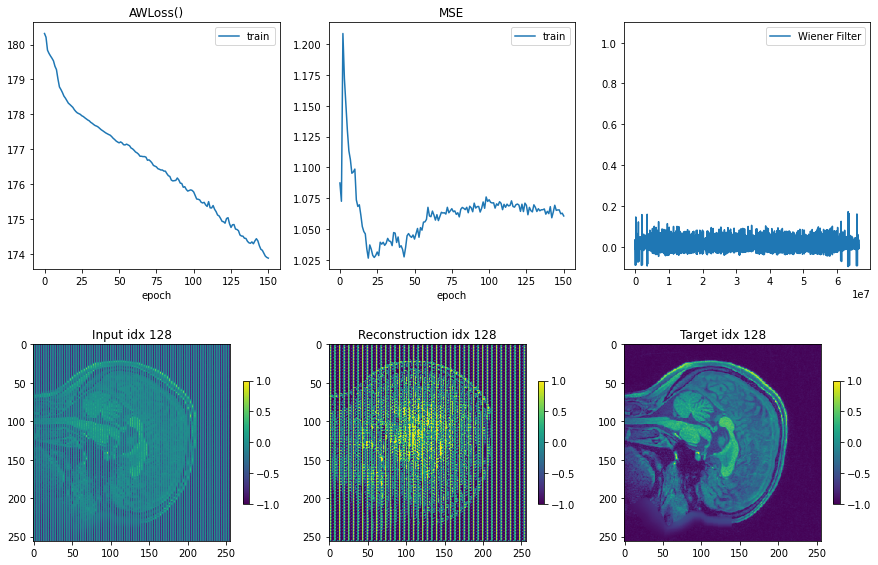

 30% (300 of 1000) |######               | Elapsed Time: 0:46:04 ETA:   1:43:28


 {'epoch': 300, 'train_loss': 170.46273803710938, 'train_mse': 1.0598105192184448}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


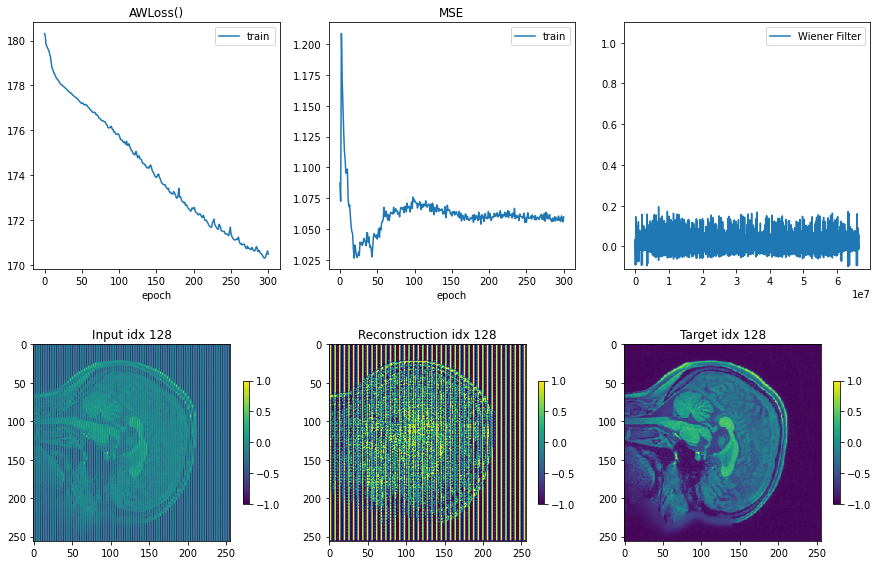

 45% (450 of 1000) |#########            | Elapsed Time: 1:08:36 ETA:   1:23:32


 {'epoch': 450, 'train_loss': 168.6015625, 'train_mse': 1.059854507446289}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


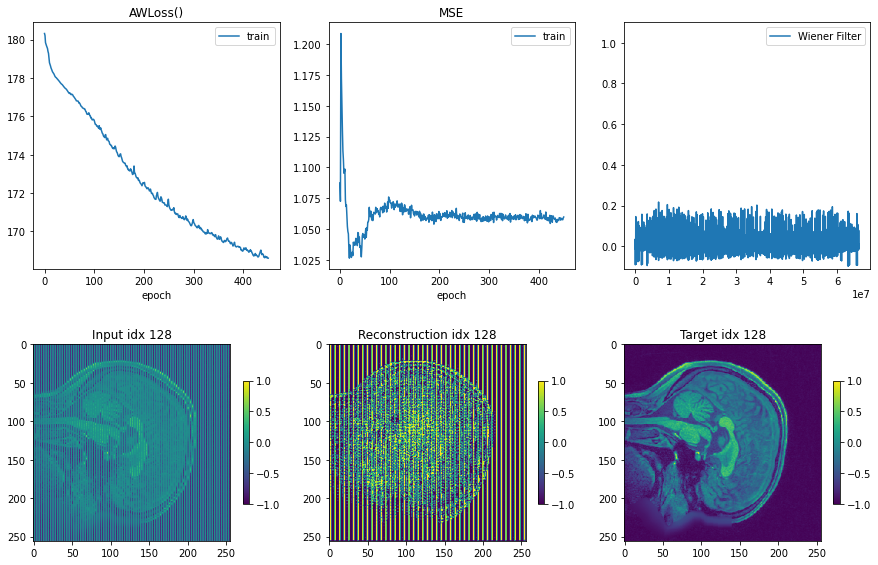

 60% (600 of 1000) |############         | Elapsed Time: 1:31:04 ETA:   0:57:44


 {'epoch': 600, 'train_loss': 167.58413696289062, 'train_mse': 1.062821388244629}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


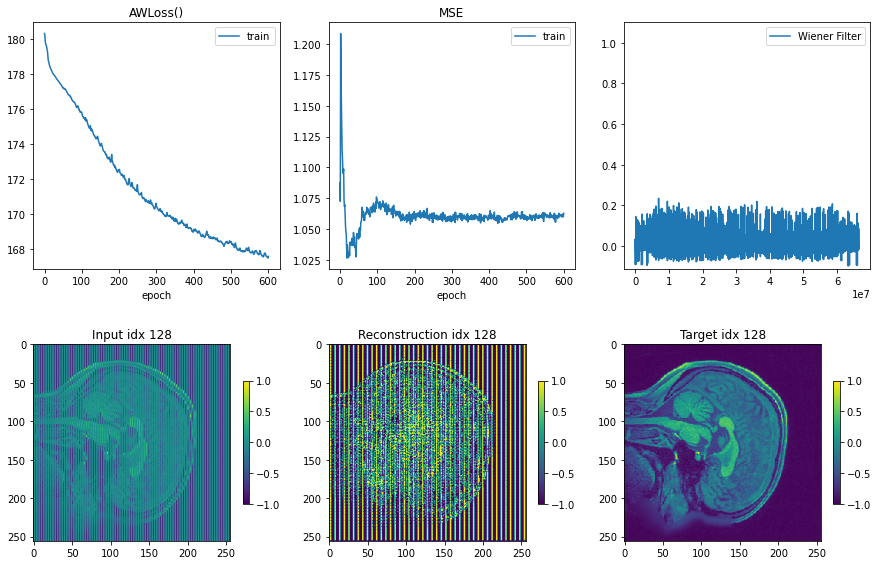

 75% (750 of 1000) |###############      | Elapsed Time: 1:53:37 ETA:   0:37:36


 {'epoch': 750, 'train_loss': 166.99588012695312, 'train_mse': 1.0528709888458252}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


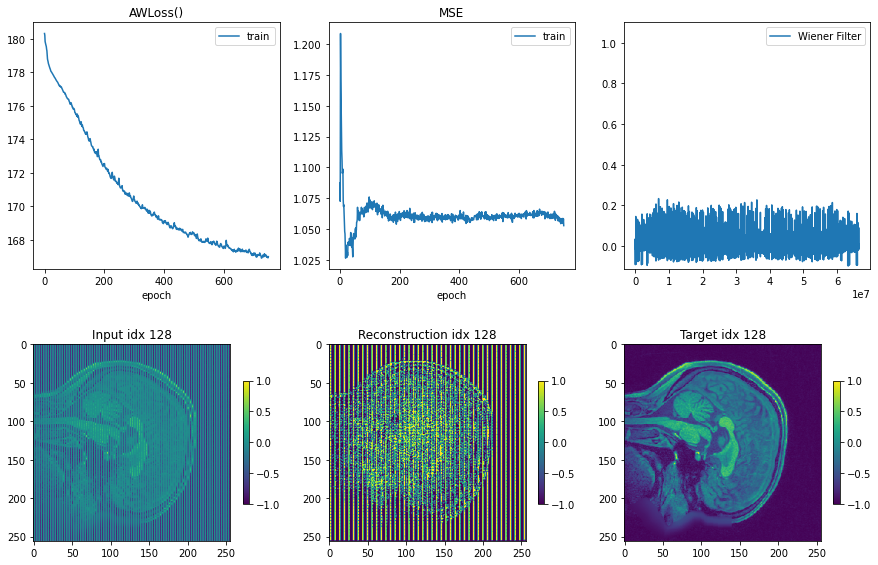

 90% (900 of 1000) |##################   | Elapsed Time: 2:16:04 ETA:   0:14:17


 {'epoch': 900, 'train_loss': 166.45465087890625, 'train_mse': 1.0576503276824951}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


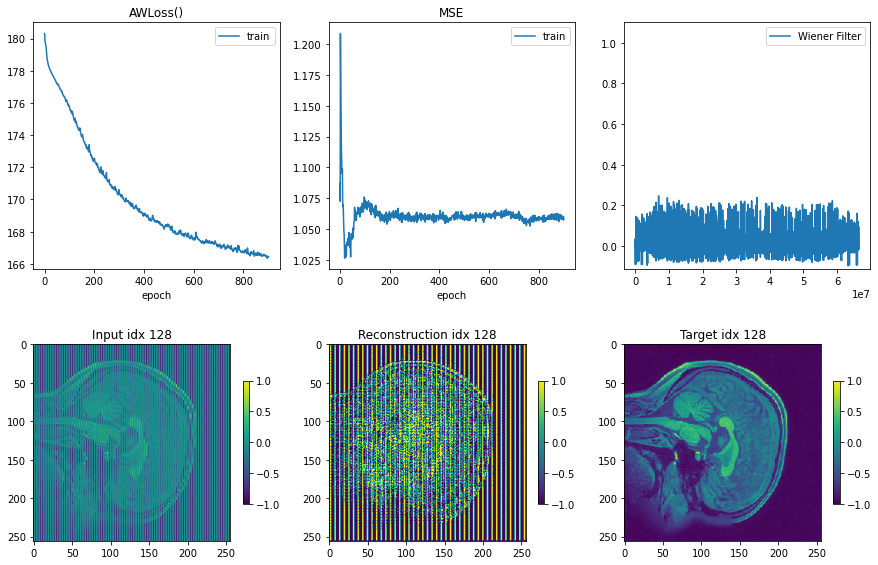

 99% (999 of 1000) |#################### | Elapsed Time: 2:31:02 ETA:   0:00:08


 {'epoch': 999, 'train_loss': 166.19845581054688, 'train_mse': 1.05994713306427}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 6919706


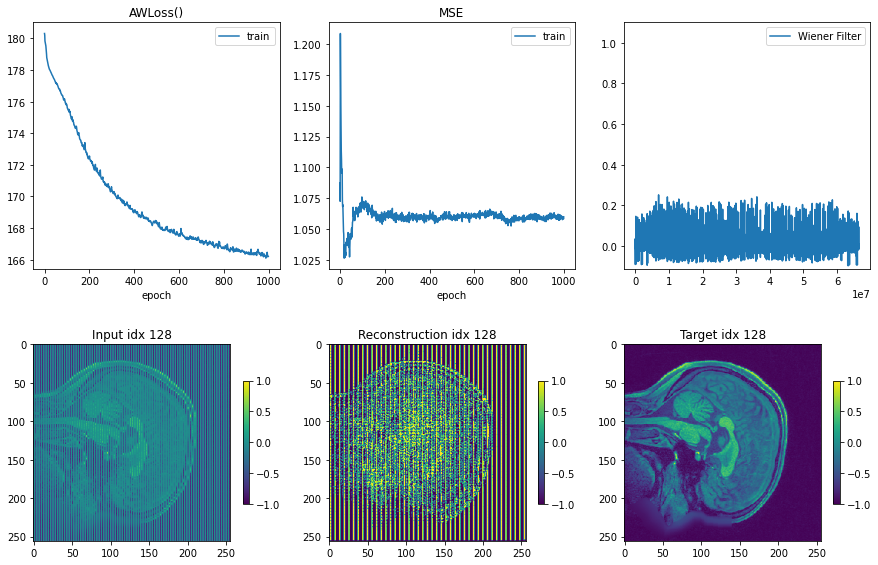

100% (1000 of 1000) |####################| Elapsed Time: 2:31:32 Time:  2:31:32


In [21]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate*10)

awloss     = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)

train_model(model, optimizer, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss + MSE



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 181.37417602539062, 'train_mse': 1.0507776737213135}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 64366326


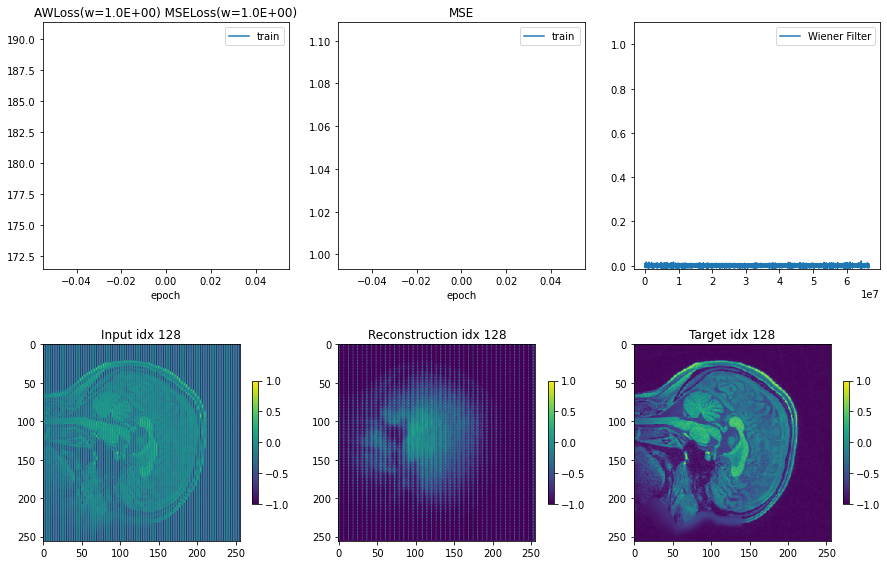

 15% (150 of 1000) |###                  | Elapsed Time: 0:22:25 ETA:   1:59:54


 {'epoch': 150, 'train_loss': 172.9759521484375, 'train_mse': 0.2730956971645355}
torch.Size([256, 256, 256]) torch.Size([256, 256, 256])
 argidx T, v:  130560 63844084


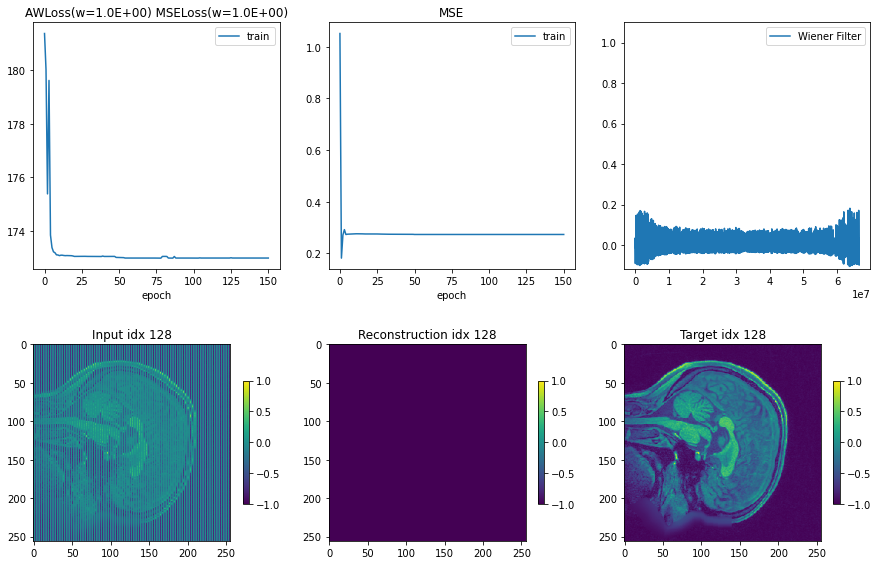

100% (1000 of 1000) |####################| Elapsed Time: 0:34:03 Time:  0:34:03


KeyboardInterrupt: 

In [22]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate*10)

awloss      = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)
mseloss     = nn.MSELoss(reduction="mean")
combined    = JointLoss((awloss, mseloss), (1., 1.), norm=False)

train_model(model, optimizer, combined, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)